## Necessary libraries

In [7]:
# Importing libraries and modules for data analysis, processing, and modeling

from functools import reduce  # For data manipulation
from collections import Counter  # For data manipulation
from scipy.optimize import minimize
# For measuring the time it takes to execute certain code blocks
import time  
from datetime import datetime  

import numpy as np  # For data processing and analysis
import pandas as pd  # For data processing and analysis

# For data visualization purposes
import seaborn as sns  
import matplotlib.pyplot as plt  

# For handling missing values and standardization
from sklearn.impute import SimpleImputer  
from sklearn.impute import KNNImputer  

from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer  

# For building predictive models
from sklearn.linear_model import BayesianRidge  
from sklearn.tree import DecisionTreeRegressor  # Also used in ensemble
from sklearn.neighbors import KNeighborsRegressor  

# For standardization
from sklearn.preprocessing import StandardScaler  
from sklearn.preprocessing import MinMaxScaler  

# For predictive modeling
from sklearn.linear_model import ElasticNetCV  
from sklearn.linear_model import ElasticNet  
from sklearn.linear_model import LassoCV  
from sklearn.linear_model import Lasso  

# For building ensembles
from sklearn.ensemble import AdaBoostRegressor  
from sklearn.ensemble import RandomForestRegressor  
from sklearn.ensemble import StackingRegressor  

# Accelerated version of Gradient Boosting
from sklearn.experimental import enable_hist_gradient_boosting  
from sklearn.ensemble import HistGradientBoostingRegressor  

# XGBoost
from xgboost import XGBRegressor  

# For building and evaluating models
from sklearn.pipeline import make_pipeline  
from sklearn.model_selection import KFold  
from sklearn.model_selection import RandomizedSearchCV  
from sklearn.model_selection import train_test_split  
from sklearn.model_selection import cross_val_score  
from sklearn.model_selection import GridSearchCV  

from sklearn.metrics import mean_squared_error  
from sklearn.metrics import r2_score  
import warnings                            # import warnings library to suppress warnings
warnings.filterwarnings(action="ignore")   # ignore any warning messages during execution
%matplotlib inline

set()
{'Andromeda XII', 'Tucana Dwarf', 'Triangulum Galaxy (M33)', 'Andromeda XXII[57]', 'Andromeda XXIV', 'NGC 5253', 'Hercules Dwarf', 'Andromeda XVIII[60]', 'Andromeda XIX[60]'}
[('Tucana Dwarf', 26), ('Andromeda XXII[57]', 26), ('Andromeda XXIV', 26), ('Andromeda XII', 26), ('Andromeda XIX[60]', 26), ('IC 1613 (UGC 668)', 25), ('Boötes IV', 25), ('Andromeda XX', 25), ('Andromeda II', 25), ('Phoenix Dwarf Galaxy (P 6830)', 25), ('Pisces IV (Andromeda XIV)', 25), ('Andromeda XV', 25), ('Cetus III', 25), ('Triangulum Galaxy (M33)', 25), ('Pegasus III', 25), ('Pisces Dwarf', 25), ('Leo IV Dwarf', 25), ('Eridanus II', 25), ('Canes Venatici II Dwarf', 25), ('IC 10 (UGC 192)', 25), ('M32 (NGC 221)', 25), ('Pegasus Dwarf Sph (And VI)', 25), ('Cassiopeia III (Andromeda XXXII)', 25), ('NGC 147 (DDO 3)', 25), ('Pisces II', 25), ('Andromeda XXVIII', 25), ('Andromeda XXV', 25), ('Andromeda VIII', 25), ('Andromeda XXIII', 25), ('Cetus Dwarf', 25), ('Pisces V (Andromeda XVI)', 25), ('Virgo I', 24

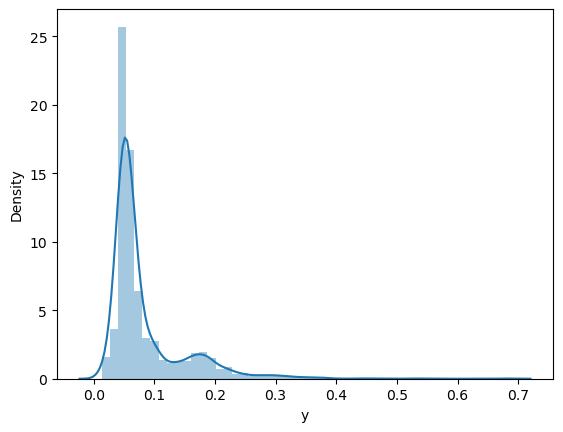

In [25]:
# import the data
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_sample_submit = pd.read_csv('sample_submit.csv')
df_sample_submit.shape # (890, 3)
# check unique galaxies in training and test data
galaxies_train = set(df_train.galaxy)
galaxies_test = set(df_test.galaxy)

print(galaxies_test - galaxies_train) # set()
print(galaxies_train - galaxies_test) # {'Andromeda XXIV', 'Andromeda XVIII[60]', 'Triangulum Galaxy (M33)',
# 'Andromeda XXII[57]', 'Tucana Dwarf', 'Andromeda XII', 'Andromeda XIX[60]', 'NGC 5253', 'Hercules Dwarf'}

# count the number of each galaxy in training data
galaxies_train_dict = Counter(df_train.galaxy)
print(galaxies_train_dict.most_common())

# training data has more galaxies, which is good, try to use dummy galaxies
dummy_train = pd.get_dummies(df_train['galaxy'])
df_train = pd.concat([df_train, dummy_train], axis=1)
df_train.drop(columns='galaxy', inplace=True)

dummy_test = pd.get_dummies(df_test['galaxy'])
df_test = pd.concat([df_test, dummy_test], axis=1)
df_test.drop(columns='galaxy', inplace=True)

# remove the target variable
y_train = df_train['y']
X_train = df_train.drop(columns=['y'])

# fill in missing columns
X_test = df_test.copy()
for col in list(galaxies_train - galaxies_test):
    X_test[col] = 0

# check the shape of X_train and X_test
print(X_train.shape) # (3865, 259)
print(X_test.shape) # (890, 259)

# check the target variable
print(y_train.describe())
sns.distplot(y_train)
plt.show()


In [12]:
good_imputer = IterativeImputer(random_state = 0, estimator = BayesianRidge())
X_train_f = good_imputer.fit_transform(X_train)
pd.DataFrame(X_train_f).to_csv("BayesianRidge_X_train.csv", index = False)
X_train_fill = pd.read_csv("BayesianRidge_X_train.csv")

# define list of regression models to tune
estimators = [
    ElasticNet(),
    AdaBoostRegressor(),
    RandomForestRegressor(),
    HistGradientBoostingRegressor(),
    XGBRegressor()
]

# define hyperparameters to search through for each model
tuned_parameters = [
    # ElasticNet hyperparameters
    {'normalize': [True], 'alpha': [8.68511373751352e-06], 'l1_ratio': [0.1], 'max_iter': [2000]},
    
    # AdaBoostRegressor hyperparameters
    {'n_estimators': [15, 20, 25], 'random_state': [0]},
    
    # RandomForestRegressor hyperparameters
    {'n_estimators': [250], 'random_state': [0], 'max_depth': range(18, 21, 1)},
    
    # HistGradientBoostingRegressor hyperparameters
    {'max_iter': [250], 'random_state': [0], 'max_depth': [11]},
    
    # XGBRegressor hyperparameters
    {'n_estimators': [250], 'min_child_weight': range(1, 6, 2), 'gamma': [0.5, 1.0], 'subsample': [0.8, 1.0], \
    'colsample_bytree': [0.7, 1.0], 'random_state': [0], 'max_depth': range(3, 10, 2)}
]

# perform hyperparameter tuning for each model and store results
i = 0
all_info = [np.nan for i in range(len(estimators))]
grid_scores = [np.inf for i in range(len(estimators))]
best_params = [np.nan for i in range(len(estimators))]

for t, br_estimator in enumerate(estimators):
    time = datetime.now()
    print("Estimator: {}".format(br_estimator.__class__.__name__))
    
    # use GridSearchCV to search through hyperparameters
    clf = GridSearchCV(br_estimator, tuned_parameters[t])
    clf.fit(X_train_fill, y_train)
    
    # store grid search results
    all_info[i] = clf.cv_results_
    grid_scores[i] = clf.best_score_
    best_params[i] = clf.best_params_
    
    # print best score and best parameters found
    print(grid_scores[i])
    print(best_params[i])
    i += 1


Estimator: ElasticNet
0.9324880046093638
{'alpha': 8.68511373751352e-06, 'l1_ratio': 0.1, 'max_iter': 2000, 'normalize': True}
Estimator: AdaBoostRegressor
0.7486502151280982
{'n_estimators': 15, 'random_state': 0}
Estimator: RandomForestRegressor
0.8924535068715576
{'max_depth': 20, 'n_estimators': 250, 'random_state': 0}
Estimator: HistGradientBoostingRegressor
0.8536251709930601
{'max_depth': 11, 'max_iter': 250, 'random_state': 0}
Estimator: XGBRegressor
0.6788785562135718
{'colsample_bytree': 0.7, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 250, 'random_state': 0, 'subsample': 1.0}


In [ ]:
# vaxt az olduqu ucun digerleri ile davam etmiyecem Elastic nete 10 validation ile baxaq ancaq ,enyuksek netice onda gorsendi

In [15]:
# Read the imputed training data
X_train_f = pd.read_csv("BayesianRidge_X_train.csv")

# Define 10-fold cross-validation
k_f = KFold(n_splits=10, shuffle=True, random_state=0)

reg = StackingRegressor(estimators=estims,
                         final_estimator=ElasticNetCV(l1_ratio=0.1, normalize=True, max_iter=2000),       # 2000 iter best_paramsdan geldi , mene maraqli olduqu ucun yolxadim daha az yolxaya bilersiniz / p.s Shareden evvel bu commentleri sil.
                         passthrough=True)
reg_score = cross_val_score(reg, X_train_f, y_train, scoring='r2', cv=k_f)
np.round(np.mean(reg_score), 3) # 0.952
print("Time: {}".format(datetime.now() - time))
print("----------------------------------------------------------")

Time: 1:18:24.536767
----------------------------------------------------------


## Mini-Test

In [17]:
#Splitting the training data into a training and testing set
X_train_betta, X_test_betta, y_train_betta, y_test_betta = train_test_split(X_train, y_train, train_size = 0.8, random_state = 0) 

#Creating an instance of the BayesianRidge estimator and using it to fill in missing values in the training and testing sets
good_imputer = IterativeImputer(random_state = 0, estimator = BayesianRidge())
good_imputer.fit(X_train_betta)
X_train_betta_f = good_imputer.transform(X_train_betta)
X_test_betta_f = good_imputer.transform(X_test_betta)


#Creating a StackingRegressor using the above estimator list and ElasticNetCV as the final estimator
reg = StackingRegressor(estimators = estims, final_estimator = ElasticNetCV(l1_ratio = 0.1, normalize = True, max_iter = 1500), passthrough = True)
reg.fit(X_train_betta_f, y_train_betta)

#Predicting the target values for both the training and testing sets
y_train_pred_betta = reg.predict(X_train_betta_f)
y_test_pred_betta = reg.predict(X_test_betta_f)

#Calculating the R2 score and root mean squared error for the training set
r2_train_betta = r2_score(y_train_betta, y_train_pred_betta)
rmse_train_betta = mean_squared_error(y_train_betta, y_train_pred_betta, squared = False)

#Printing the R2 score and root mean squared error for the training set
print("R2: {0:.3f}, RMSE: {1:.5f}".format(r2_train_betta, rmse_train_betta)) # R2: 0.978, RMSE: 0.00904

#Calculating the R2 score and root mean squared error for the testing set
r2_test_betta = r2_score(y_test_betta, y_test_pred_betta)
rmse_test_betta = mean_squared_error(y_test_betta, y_test_pred_betta, squared = False)

#Printing the R2 score and root mean squared error for the testing set
print("R2: {0:.3f}, RMSE: {1:.5f}".format(r2_test_betta, rmse_test_betta)) # R2: 0.922, RMSE: 0.01982

R2: 0.978, RMSE: 0.00901
R2: 0.920, RMSE: 0.02001


In [20]:
#Createing an instance of IterativeImputer with BayesianRidge estimator and set the random_state to 0
good_imputer = IterativeImputer(random_state = 0, estimator = BayesianRidge())

#Fit the imputer to the training data (X_train)
good_imputer.fit(X_train)

#Transform the training data using the fitted imputer
X_train_f = good_imputer.transform(X_train)

#Transform the test data using the fitted imputer
X_test_f = good_imputer.transform(X_test)

##  1) Predicted future Index values

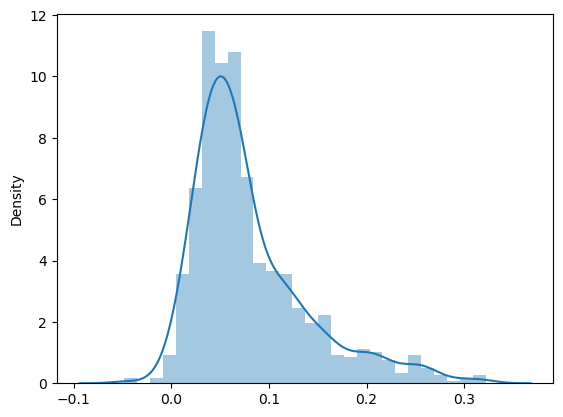

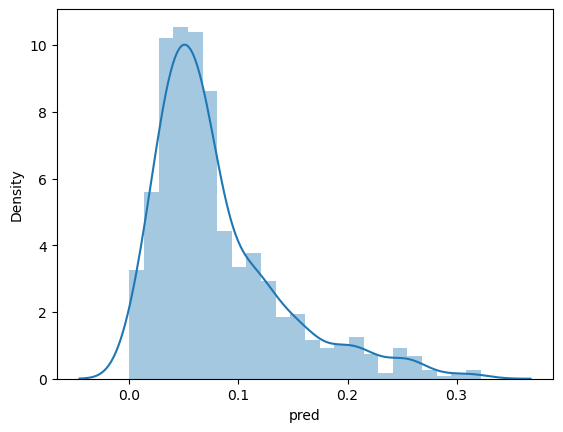

In [26]:
#StackingRegressor model with ElasticNetCV final estimator
reg = StackingRegressor(estimators = estims, final_estimator = ElasticNetCV(l1_ratio = 0.1, normalize = True, max_iter = 1500), passthrough = True)

#Train the model on the transformed training data
reg.fit(X_train_f, y_train)

#Use the trained model to predict the target values for the transformed test data
y_pred = reg.predict(X_test_f)
df_sample_submit["pred"] = y_pred

(y_pred < 0).sum() # 10 штучек, в случае стэкинга, 0 в XGBRegressor
sns.distplot(y_pred)
plt.show()

df_sample_submit.loc[y_pred < 0, "pred"] = 0
df_sample_submit.pred.describe()
sns.distplot(df_sample_submit.pred)
plt.show()

## 2) Allocated energy from a newly discovered star

In [27]:
from scipy.optimize import minimize

# initial guess for parameters
extra_energy = np.array(df_sample_submit['opt_pred'])


# vector to multiply with
potential_increase_in_index = - np.log(df_sample_submit.pred + 0.01) + 3
# calculate the likely increase in index part
likely_increase_in_index_part = potential_increase_in_index ** 2 / 1000


# final function for minimization (by putting minus sign in one of the vectors, it becomes kinda maximization)
likely_increase_in_index = lambda likely_increase_in_index_part, extra_energy: np.dot(extra_energy, -likely_increase_in_index_part)


# Galaxies with low existence expectancy index below 0.7 should be allocated at least 10% of the total energy available in the foreseeable future
# needed for constraint:
existence_expectancy_index_bool = (X_test_f[:, 1] < 0.7).astype(int)


In [29]:

# constraints
cons = (
    {'type': 'ineq',
     'fun': lambda existence_expectancy_index_bool, extra_energy: np.dot(existence_expectancy_index_bool, extra_energy) - 5000,
     'jac': lambda existence_expectancy_index_bool, extra_energy: existence_expectancy_index_bool,
     'args': (existence_expectancy_index_bool, )},
    {'type': 'ineq',
     'fun': lambda extra_energy: np.sum(extra_energy) - 49999.999,
     'jac': lambda extra_energy: np.ones(len(extra_energy))}
)

# запускаем минимизацию
# start minimization
res = minimize(
    fun=likely_increase_in_index, # the function to minimize
    x0=extra_energy, # initial guess
    args=(likely_increase_in_index_part, ), # extra arguments for the function
    jac=lambda likely_increase_in_index_part, extra_energy: likely_increase_in_index_part, # function to compute the Jacobian (optional)
    bounds=[(0, 100) for i in range(890)], # bounds for the variables
    method='SLSQP', # method to use for optimization
    constraints=cons, # constraints to apply
    options={'maxiter': 1000} # additional options for the solver
)

# print the solution vector
print(res.x)
# print the sum of the solution vector
print(sum(res.x))
# print whether the optimization was successful
print(res.success)
# print the final value of the function
print(np.dot(res.x, -likely_increase_in_index_part))
# print the energy allocated to galaxies with low existence expectancy index
print(np.dot(existence_expectancy_index_bool, res.x))


# save the attempts
df_sample_submit["opt_pred"] = res.x

# save the predictions to a CSV file
df_sample_submit.to_csv("Attempt_ProHack_Challenge_2020.csv", index=False)


[89.23430477 89.23430477 89.23430477 89.23430477 89.23430477 89.23430477
 89.23430477 89.23430477 89.23430477 89.23430477 89.23430477 89.23430477
 89.23430477 89.23430477 89.23430477 89.23430477 89.23430477 89.23430477
 89.23430477 89.23430477 89.23430477 89.23430477 89.23430477 89.23430477
 89.23430477 89.23430477 89.23430477 89.23430477 89.23430477 89.23430477
 89.23430477 89.23430477 89.23430477 89.23430477 89.23430477 89.23430477
 89.23430477 89.23430477 89.23430477 89.23430477 89.23430477 89.23430477
 89.23430477 89.23430477 89.23430477 89.23430477 89.23430477 89.23430477
 89.23430477 89.23430477 89.23430477 89.23430477 89.23430477 89.23430477
 89.23430477 89.23430477 89.23430477 89.23430477 89.23430477 89.23430477
 89.23430477 89.23430477 89.23430477 89.23430477 89.23430477 89.23430477
 89.23430477 89.23430477 89.23430477 89.23430477 89.23430477 89.23430477
 89.23430477 89.23430477 89.23430477 89.23430477 89.23430477 89.23430477
 89.23430477 89.23430477 89.23430477 89.23430477 89